In [1]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import torch
import os

In [9]:
ANNOTATIONS_FILE = "UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_DIR = "UrbanSound8K/audio/"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Signal:  torch.Size([2, 14004])
Sampling rate:  44100

Signal:  torch.Size([2, 7002])

Signal:  torch.Size([1, 7002])

Signal:  torch.Size([1, 7002])

Signal:  torch.Size([1, 22050])

Mel Spectrogram:  torch.Size([1, 64, 44])


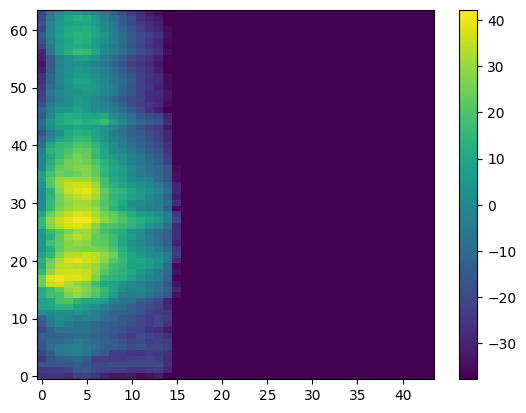

In [10]:
item = 0
annotations = pd.read_csv(ANNOTATIONS_FILE)
fold = f"fold{annotations.iloc[item, 5]}"
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=512,
    n_mels=64,
)

path = os.path.join(AUDIO_DIR, fold, annotations.iloc[item, 0])
label = annotations.iloc[item, 6]

signal, sr = torchaudio.load(path)
print("Signal: ", signal.shape)
print("Sampling rate: ", sr)
print()

if sr != SAMPLE_RATE:
    resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
    signal = resampler(signal)
print("Signal: ", signal.shape)
print()

if signal.shape[0] > 1:
    signal = torch.mean(signal, dim=0, keepdim=True)
print("Signal: ", signal.shape)
print()

if signal.shape[1] > NUM_SAMPLES:
    signal = signal[:, :NUM_SAMPLES]
print("Signal: ", signal.shape)
print()

if signal.shape[1] < NUM_SAMPLES:
    num_missing_samples = NUM_SAMPLES - signal.shape[1]
    last_dim_padding = (0, num_missing_samples)
    signal = torch.nn.functional.pad(signal, last_dim_padding)
print("Signal: ", signal.shape)
print()

mel_specs = mel_spectrogram(signal)
print("Mel Spectrogram: ", mel_specs.shape)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(librosa.power_to_db(mel_specs[0]), origin="lower", aspect="auto")
fig.colorbar(im, ax=ax)
plt.show(block=False)

In [11]:
class UrbanSoundDataset(Dataset):
    def __init__(self, annotation_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotation_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, item):
        audio_sample_path = self._get_audio_sample_path(item)
        label = self._get_audio_sample_label(item)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        mel_specs = self.transformation(signal)
        return mel_specs, label
    
    def _get_audio_sample_path(self, item):
        fold = f"fold{annotations.iloc[item, 5]}"
        path = os.path.join(AUDIO_DIR, fold, annotations.iloc[item, 0])
        return path
    
    def _get_audio_sample_label(self, item):
        return annotations.iloc[item, 6]
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)        
        return signal
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

In [12]:
from torch import nn

class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()

        self.linear = nn.Linear(in_features=128 * 5 * 4, out_features=10)

        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [13]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # Loss
        predictions = model(input)
        loss = loss_fn(predictions, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Loss: {loss.item()}")

def train(model, data_loader, loss_fn, optimizer, epochs, device):
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        train_single_epoch(model, data_loader, loss_fn, optimizer, device)
        print("----------------------------------------------------------------------------------------")
    print("Training completed!")

In [14]:
# Transformations
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

# Dataset
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)

# Data loader
train_dataloader = create_data_loader(usd, BATCH_SIZE)

# Model
model = CNNNetwork().to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
train(model, train_dataloader, loss_fn, optimizer, EPOCHS, device)

Epoch: 1
Loss: 2.336031198501587
----------------------------------------------------------------------------------------
Epoch: 2
Loss: 2.3346080780029297
----------------------------------------------------------------------------------------
Epoch: 3
Loss: 2.3311188220977783
----------------------------------------------------------------------------------------
Epoch: 4
Loss: 2.3415424823760986
----------------------------------------------------------------------------------------
Epoch: 5
Loss: 2.3353652954101562
----------------------------------------------------------------------------------------
Epoch: 6
Loss: 2.3164565563201904
----------------------------------------------------------------------------------------
Epoch: 7
Loss: 2.3179259300231934
----------------------------------------------------------------------------------------
Epoch: 8
Loss: 2.3178558349609375
----------------------------------------------------------------------------------------
Epoch: 9
Loss: 2.

In [ ]:
torch.save(model.state_dict(), "usd_sound_classifier.pth")